In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import neurokit2 as nk
from heartkit.defines import HeartTask
from heartkit.datasets.icentia11k import IcentiaDataset
from heartkit.datasets.ludb import LudbDataset 
from heartkit.datasets.synthetic import SyntheticDataset
from heartkit.datasets.synthetic.rhythm_generator import generate_nsr
from heartkit.datasets.preprocess import preprocess_signal

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [17]:
def plot_segmentations(data, labels=None, preds=None, fig=None, ax=None):
    color_map = {0: 'gray', 1: 'blue', 2: 'red', 3: 'green'}

    t = np.arange(0, data.shape[0])
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(t, data)
    if preds is not None:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], 'black')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)

    return fig, ax


In [18]:
ds_path = "../datasets"
frame_size = 1248
frame_overlap = 312
frame_keep = frame_size - frame_overlap
patient = 4


In [19]:
ds = LudbDataset(
    ds_path=ds_path,
    task=HeartTask.segmentation,
    frame_size=frame_size
)

In [5]:
ds2 = SyntheticDataset(
    ds_path="../datasets",
    task=HeartTask.segmentation,
    frame_size=frame_size
)

In [8]:
model = tf.keras.models.load_model("../results/segmentation/model.tf")

In [5]:
data, labels = ds.get_patient_data_segments(patient=patient)

In [34]:
y_pred = np.zeros_like(labels)
for lead_idx in range(data.shape[1]):
    for i in range(0, data.shape[0] - frame_keep + 1, frame_keep):
        y = model.predict(preprocess_signal(data[i:i+frame_size, lead_idx], sample_rate=500, target_rate=500).reshape((1, frame_size, 1)), verbose=0).squeeze()
        y_pred[i:i+frame_keep, lead_idx] = y[:frame_keep].argmax(axis=1)
    # END FOR   
# END FOR

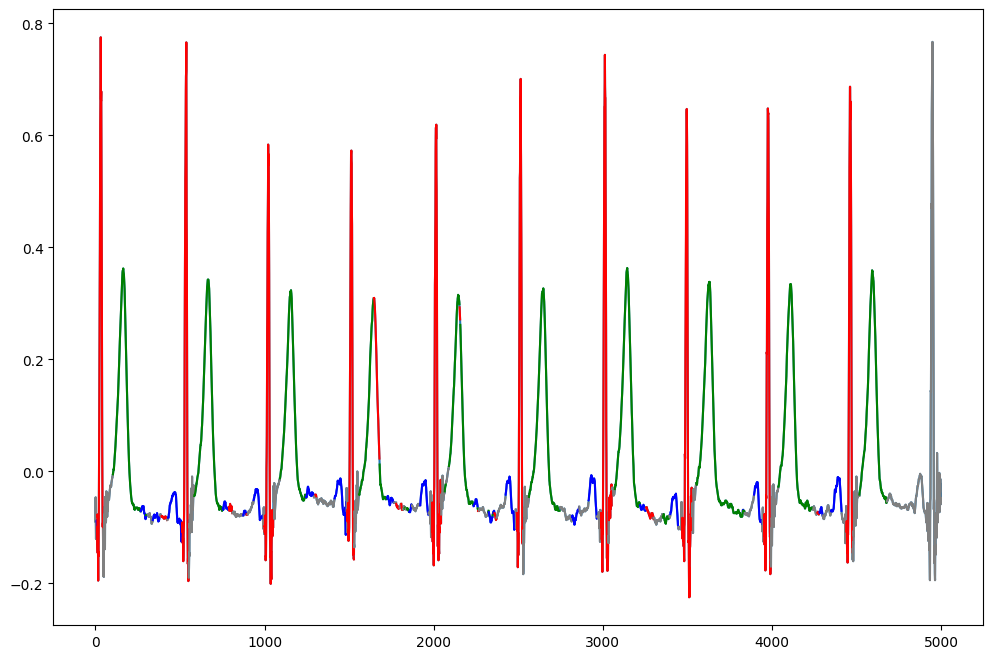

In [36]:
lead_idx = 0
fig, ax = plot_segmentations(data=data[:, lead_idx], labels=None, preds=y_pred[:, lead_idx])
fig.show()

In [ ]:
ecg = nk.ecg_simulate(duration=10, heart_rate=60, sampling_rate=500)

In [ ]:
y_pred = np.zeros_like(ecg)
for i in range(0, ecg.shape[0] - frame_keep + 1, frame_keep):
    y = model.predict(ecg[i:i+frame_size].reshape((1, frame_size, 1)), verbose=0).squeeze()
    y_pred[i:i+frame_keep] = y[:frame_keep].argmax(axis=1)
# END FOR  

In [ ]:
fig, ax = plot_segmentations(data=ecg, labels=None, preds=y_pred.squeeze())
fig.show()

* Use LUDB, QT, and Synthetic to train 
* Need to resample to 500 Hz (use all leads)
* Apply augmentations: inject noise, artifacts
* Apply filter, baseline wander removal, and normalize signal 

In [ ]:
ds = IcentiaDataset(
    ds_path=ds_path,
    task=HeartTask.beat,
    frame_size=500
)

In [23]:
with tf.device('/CPU:0'):
    train_ds, val_ds = ds.load_train_datasets(
        train_patients=0.2,
        val_patients=0.2,
        train_pt_samples=50,
        val_pt_samples=50,
        num_workers=8,
    )

[02/27/23 16:38:02] INFO     Splitting patients into train and validation                            ]8;id=212619;file:///workspaces/heart-kit/heartkit/datasets/dataset.py\dataset.py]8;;\:]8;id=997535;file:///workspaces/heart-kit/heartkit/datasets/dataset.py#154\154]8;;\

                    INFO     Collecting 400 validation samples                                       ]8;id=190669;file:///workspaces/heart-kit/heartkit/datasets/dataset.py\dataset.py]8;;\:]8;id=6602;file:///workspaces/heart-kit/heartkit/datasets/dataset.py#161\161]8;;\

[02/27/23 16:38:03] INFO     Building train dataset                                                  ]8;id=94174;file:///workspaces/heart-kit/heartkit/datasets/dataset.py\dataset.py]8;;\:]8;id=644167;file:///workspaces/heart-kit/heartkit/datasets/dataset.py#179\179]8;;\

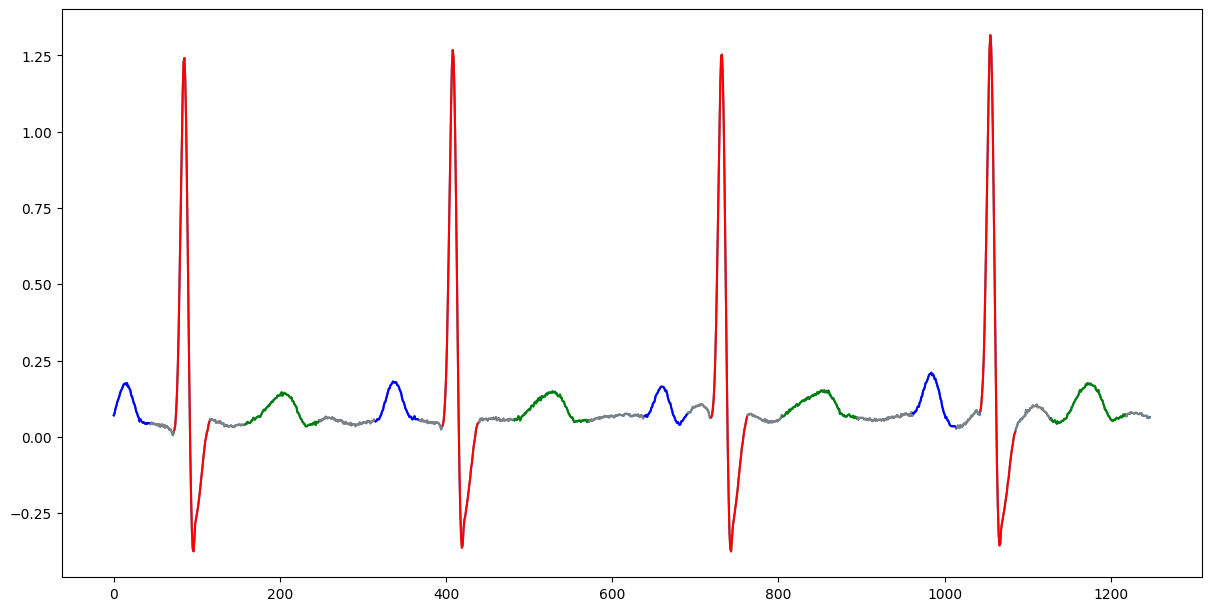

In [8]:
%matplotlib inline
import time
from IPython import display
fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")
for x, y in ds2.segmentation_generator(ds2.uniform_patient_generator([0, 1, 2, 3, 4], repeat=False), 5):
    plot_segmentations(data=x.squeeze(), labels=None, preds=y.squeeze(), fig=fig, ax=ax)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(1.0)
    ax.cla()
plt.close(fig)


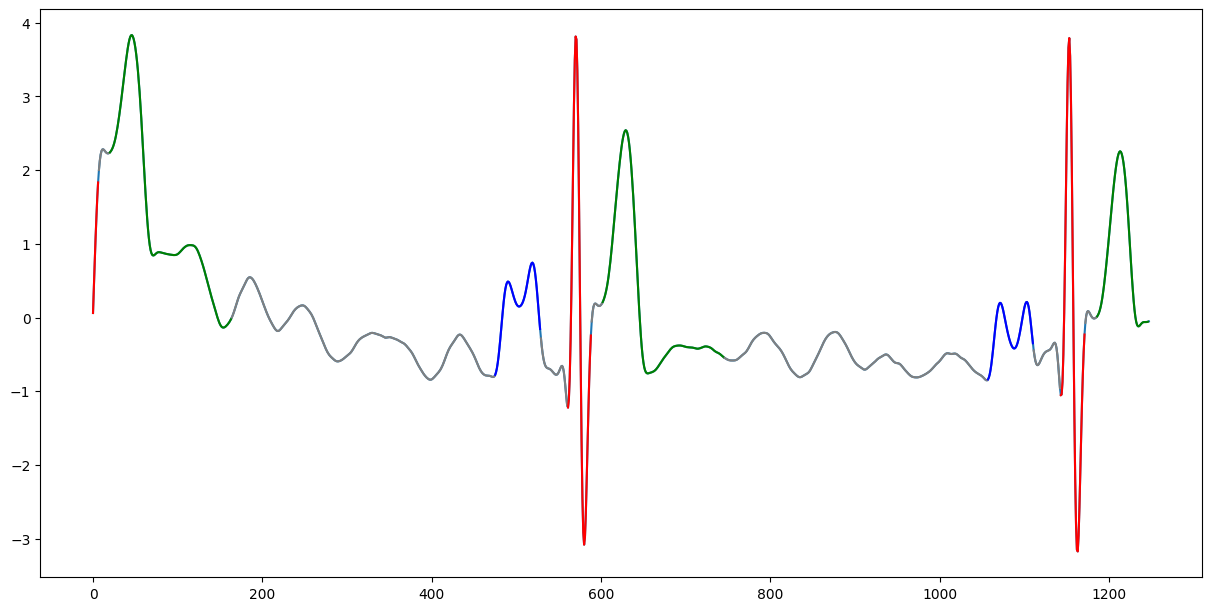

In [32]:
%matplotlib inline
import time
from IPython import display

# ds = LudbDataset(
#     ds_path=ds_path,
#     task=HeartTask.segmentation,
#     frame_size=frame_size
# )

ds = SyntheticDataset(
    ds_path=ds_path,
    task=HeartTask.segmentation,
    frame_size=frame_size
)

with tf.device('/CPU:0'):
    train_ds, val_ds = ds.load_train_datasets(
        train_patients=0.2,
        val_patients=0.2,
        train_pt_samples=50,
        val_pt_samples=50,
        num_workers=8,
    )

fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")
num_samples = 25
with tf.device('/CPU:0'):
    for x, y in train_ds.as_numpy_iterator():  
        # y_pred = model.predict(x.reshape(), verbose=0).squeeze()
        # y_pred = y_pred.argmax(axis=1)
        y = y.argmax(axis=1)
        plot_segmentations(data=x.squeeze(), labels=y.squeeze(), preds=y.squeeze(), fig=fig, ax=ax)
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(1.0)
        ax.cla()
        num_samples -= 1
        if num_samples <= 0:
            break
    plt.close(fig)

In [ ]:
syn_ts, syn_ecg, syn_segs_t, syn_fids, syn_meta = generate_nsr(
    leads=12, 
    signal_frequency=250, 
    rate=60,
    preset='SR',
    noise_multiplier=0.9,
    impedance=1,
    p_multiplier=0.9,
    t_multiplier=0.9,
    duration=30,
    voltage_factor=300
)

In [ ]:
syn_segs = np.zeros_like(syn_segs_t)
for i in range(syn_segs_t.shape[0]):
    syn_segs[i, np.where((syn_segs_t[i] == 7) | (syn_segs_t[i] == 1))[0]] = 1
    syn_segs[i, np.where((syn_segs_t[i] == 3))[0]] = 2
    syn_segs[i, np.where((syn_segs_t[i] == 5))[0]] = 3

In [ ]:
lead_idx = 0
fig, ax = plot_segmentations(data=syn_ecg[lead_idx,:1000], labels=None, preds=syn_segs[lead_idx,:1000])
fig.show()

In [21]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[02/27/23 16:36:04] INFO     INFO:tensorflow:Using MirroredStrategy with devices           ]8;id=967521;file:///workspaces/heart-kit/.venv/lib/python3.10/site-packages/tensorflow/python/distribute/mirrored_strategy.py\mirrored_strategy.py]8;;\:]8;id=28608;file:///workspaces/heart-kit/.venv/lib/python3.10/site-packages/tensorflow/python/distribute/mirrored_strategy.py#374\374]8;;\
                             ('/job:localhost/replica:0/task:0/device:GPU:0',)                                     

In [26]:
with tf.device('/CPU:0'):
    for sample in train_ds.as_numpy_iterator():    
        print(sample[1].shape)
        break

(1248, 4)
